# Project 2: Predicting House Prices from Ames, IA Dataset

---
# Problem Statement

Intuitively we know there are several key aspects of a home that help to increase its selling price. We can assume the obvious: location, square footage, lot size, etc. But how can a home owner in Ames, IA looking to sell be certain the improvements they make will increase the sale price of their home?

Through the following data analysis, I will explore a substantial data set gathrered from the Ames, Iowa Assessor’s Office in attempt to focus in on key features of a home that can be upgraded to maximize sale price. 

I will first prepare and clean the data so it is ready for analysis. Then, I will perform some Exploratory Data Analysis in attempt to gleen some preliminary results. Finally, I will build and compare several different Linear Regression models, and choosing the most appropriate based on the R-squared and RMSE (root mean squared error) metrics. The model should provide solid quantitative power in determining target features of homes to upgrade.

# Data Set Cleaning

For the data set, I have been provided a training set to perform the modeling, and a test set without the sale price in order to run the predictions. Let's get started on looking into the data.

In [676]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error

In [677]:
train = pd.read_csv('./datasets/train.csv')
train.shape

(2051, 81)

In [678]:
test = pd.read_csv('./datasets/test.csv')
test.shape

(878, 80)








This are relatively small data set, but let's get started on cleaning them up.








In [679]:
# Printing out total null values by column in train set
for null_total, col in zip(train.isnull().sum(), train.columns):
    if null_total != 0:
        print(f'{col.rjust(15)}:',(null_total, f'{str(round(null_total/train.shape[0] * 100, 2))}%'))

   Lot Frontage: (330, '16.09%')
          Alley: (1911, '93.17%')
   Mas Vnr Type: (22, '1.07%')
   Mas Vnr Area: (22, '1.07%')
      Bsmt Qual: (55, '2.68%')
      Bsmt Cond: (55, '2.68%')
  Bsmt Exposure: (58, '2.83%')
 BsmtFin Type 1: (55, '2.68%')
   BsmtFin SF 1: (1, '0.05%')
 BsmtFin Type 2: (56, '2.73%')
   BsmtFin SF 2: (1, '0.05%')
    Bsmt Unf SF: (1, '0.05%')
  Total Bsmt SF: (1, '0.05%')
 Bsmt Full Bath: (2, '0.1%')
 Bsmt Half Bath: (2, '0.1%')
   Fireplace Qu: (1000, '48.76%')
    Garage Type: (113, '5.51%')
  Garage Yr Blt: (114, '5.56%')
  Garage Finish: (114, '5.56%')
    Garage Cars: (1, '0.05%')
    Garage Area: (1, '0.05%')
    Garage Qual: (114, '5.56%')
    Garage Cond: (114, '5.56%')
        Pool QC: (2042, '99.56%')
          Fence: (1651, '80.5%')
   Misc Feature: (1986, '96.83%')


In [680]:
# Printing out total null values by column in test set
for null_total, col in zip(test.isnull().sum(), test.columns):
    if null_total != 0:
        print(f'{col.rjust(15)}:',(null_total, f'{str(round(null_total/test.shape[0] * 100, 2))}%'))

   Lot Frontage: (160, '18.22%')
          Alley: (820, '93.39%')
   Mas Vnr Type: (1, '0.11%')
   Mas Vnr Area: (1, '0.11%')
      Bsmt Qual: (25, '2.85%')
      Bsmt Cond: (25, '2.85%')
  Bsmt Exposure: (25, '2.85%')
 BsmtFin Type 1: (25, '2.85%')
 BsmtFin Type 2: (25, '2.85%')
     Electrical: (1, '0.11%')
   Fireplace Qu: (422, '48.06%')
    Garage Type: (44, '5.01%')
  Garage Yr Blt: (45, '5.13%')
  Garage Finish: (45, '5.13%')
    Garage Qual: (45, '5.13%')
    Garage Cond: (45, '5.13%')
        Pool QC: (874, '99.54%')
          Fence: (706, '80.41%')
   Misc Feature: (837, '95.33%')


After reviewing the data descriptions, most of these null values imply they should be marked as 'None', or 'N/A'. For exaple, Alley contains 90%+ null values , but the data dictionary provides this means the house has no Alley. The columns listed below will have the null values converted to `'NA'`:

**Covert Null to `'NA'`:**

    Alley
    Mas Vnr Type
    Bsmt Qual
    Bsmt Cond
    Bsmt Exposure
    BsmtFin Type 1
    BsmtFin Type 2
    Fireplace Qu
    Garage Type
    Garage Finish
    Garage Qual
    Garage Cond
    Pool QC
    Fence
    Mas Vnr Type
    Misc Feature
    
    

    
    
    
    
    

In [681]:
# Column names to convert null values to string 'NA'
na_to_str = [
    'Alley',
    'Bsmt Qual',
    'Bsmt Cond',
    'Bsmt Exposure',
    'BsmtFin Type 1',
    'BsmtFin Type 2',
    'Fireplace Qu',
    'Garage Type',
    'Garage Finish',
    'Garage Qual',
    'Garage Cond',
    'Pool QC',
    'Fence',
    'Misc Feature'
]

In [682]:
# Converting null values to string 'NA'
for col in na_to_str:
    train[col].fillna('NA', inplace=True)
    test[col].fillna('NA', inplace=True)

Where `'Mas Vnr Type'` is NA, I will change to `'None'` to coalesce with the rest of the column values.

In [683]:
train['Mas Vnr Type'].fillna('None', inplace=True)
test['Mas Vnr Type'].fillna('None', inplace=True)

Other columns with null values imply they have nothing to attribute to that category. For instance, a house without a garage should have an area equal to zero, however the data set as a null value instead. I will convert the null values to zeros for the columns listed below:

 **Covert Null to `0`:**  
        
    BsmtFin SF 1
    BsmtFin SF 2
    Bsmt Unf SF
    Total Bsmt SF
    Garage Yr Blt
    Garage Cars
    Garage Area
    Mas Vnr Area

In [684]:
# Column names to covert null values to zero
na_to_zero = [
    'BsmtFin SF 1',
    'BsmtFin SF 2',
    'Bsmt Unf SF',
    'Total Bsmt SF',
    'Garage Yr Blt',
    'Garage Cars',
    'Garage Area',
    'Mas Vnr Area'
]

In [685]:
# Converting null values to zero
for col in na_to_zero:
    train[col].fillna(0, inplace=True)
    test[col].fillna(0, inplace=True)


In digging into this null values a little deeper, I found there were some houses with the `'Mas Vnr Area' = 0` while `'Mas Vnr Type'` did not equal `'None'`. I decided to fill these with the average veneer area.

In [686]:
# Checking columns where masonry veneer area = 0 but the type does not equal none.
train.loc[
    (train['Mas Vnr Area'] == 0) & (train['Mas Vnr Type'] != 'None'),
    ['Mas Vnr Area', 'Mas Vnr Type', 'SalePrice']
]

,Mas Vnr Area,Mas Vnr Type,SalePrice
669,0.0,BrkFace,173500
1136,0.0,BrkFace,392000
1187,0.0,Stone,248328


In [687]:
test.loc[
    (test['Mas Vnr Area'] != 0) & (test['Mas Vnr Type'] == 'None'),
    ['Mas Vnr Area', 'Mas Vnr Type']
]

,Mas Vnr Area,Mas Vnr Type
382,285.0,None
862,312.0,None


In [688]:
# Replacing the average veneer area
vnr_area_mean_train = train['Mas Vnr Area'].mean()
vnr_area_mean_test = train['Mas Vnr Area'].mean()
train.loc[(train['Mas Vnr Area'] == 0) & (train['Mas Vnr Type'] != 'None'),'Mas Vnr Area']= vnr_area_mean_train
test.loc[(test['Mas Vnr Area'] == 0) & (test['Mas Vnr Type'] != 'None'),'Mas Vnr Area']= vnr_area_mean_test

Inversely, I found houses with `'Mas Vnr Type' = 'None'` where `'Mas Vnr Area'` did not equal zero. I decided to fill these with masonry type `'None'`. digging into this null values a little deeper, I found there were some houses with the `'Mas Vnr Area' = 0` while `'Mas Vnr Type'` did not equal `'None'`. I decided to fill these with the average veneer area.

In [689]:
# Checking columns where masonry veneer area does not equal zerobut the type = None.
train.loc[
    (train['Mas Vnr Area'] != 0) & (train['Mas Vnr Type'] == 'None'),
    ['Mas Vnr Area', 'Mas Vnr Type', 'SalePrice']
]

,Mas Vnr Area,Mas Vnr Type,SalePrice
765,1.0,None,190000
810,288.0,None,165150
1148,1.0,None,114500
1684,1.0,None,104500
1832,344.0,None,225000


In [690]:
test.loc[
    (test['Mas Vnr Area'] != 0) & (test['Mas Vnr Type'] == 'None'),
    ['Mas Vnr Area', 'Mas Vnr Type']
]

,Mas Vnr Area,Mas Vnr Type
382,285.0,None
862,312.0,None


In [691]:
# Setting masonry area to zero.
train.loc[(train['Mas Vnr Area'] != 0) & (train['Mas Vnr Type'] == 'None'),'Mas Vnr Area'] = 0
test.loc[(test['Mas Vnr Area'] != 0) & (test['Mas Vnr Type'] == 'None'),'Mas Vnr Area'] = 0

I will omit the rows where Basment Full and Bath values are null as I believe they are of such small percentage that it will have a negligible impact on the model..

In [692]:
# Dropping rows where Basement Full & Half Bath values are null.
train.dropna(axis=0, subset=['Bsmt Full Bath', 'Bsmt Half Bath'], inplace=True)

As there is a relatively signifacant amount of null values in `'Lot Frontage'`, I will replace those with the median value.

In [693]:
train['Lot Frontage'].fillna(train['Lot Frontage'].mean(),inplace=True)
test['Lot Frontage'].fillna(test['Lot Frontage'].mean(),inplace=True)

Finally, I'll fill that null value in the `'Electrical'` column with the overwhelming common value of `'SBrkr'`.

In [694]:
# Filling null values in Elecdtrical column to match the majority.
test['Electrical'].fillna('SBrkr', inplace=True)

I believe that takes care of all the null values, but let's check one last time to make sure.

In [695]:
# Checking for null values one last time
print(f'train nulls: {sum(train.isnull().sum())}')
print(f'tedst nulls: {sum(test.isnull().sum())}')


train nulls: 0
tedst nulls: 0


I want to take care of one final item before investigating the Sales Price. The data dictionary provided recommended removing some outliers where the square footage is greater tahn 4000 sf ([source](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)). Let's take a look and see if I should remove them.

Text(0.5, 1.0, 'Living Square Footage vs Sale Price')

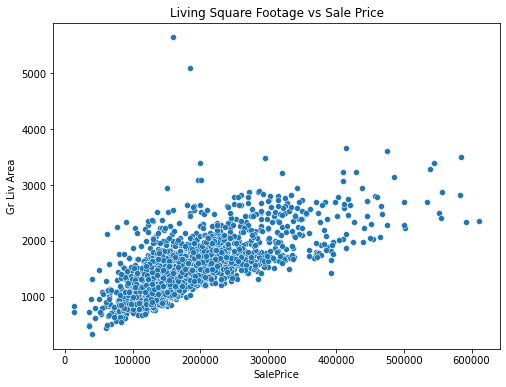

In [696]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train['SalePrice'], y=train['Gr Liv Area'])
plt.title('Living Square Footage vs Sale Price')

There are two obvious outliers near the 5,000 sf mark with a sale price below $200k. I'll remove them as recommended.

In [697]:
# Removing sales where living area is greater than 4,000 sf
#
# Idea of below code taken from site below:
# https://www.geeksforgeeks.org/how-to-drop-rows-in-dataframe-by-conditions-on-column-values/

indx = train[train['Gr Liv Area'] > 4000].index
train.drop(index=indx, inplace = True) 

### Categorical Features

There are loads of categorical features in this data set, some ordinal, so I'll need to covert these before analysis.

In [698]:
# Creating dictionaries of ordinal values to convert the categorical columns.
lot_shape_d = {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1}
util_d = {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1}
land_slope_d = {'Gtl': 3, 'Mod': 2, 'Sev': 1}
ext_qual_d = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
ext_cond_d = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
bsmt_qual_d = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
bsmt_cond_d = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
bsmt_exp_d = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
bsmt_fin1_d = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3,'LwQ': 2, 'Unf': 1, 'NA': 0}
bsmt_fin2_d = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3,'LwQ': 2, 'Unf': 1, 'NA': 0}
heat_qc_d = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
elect_d = {'SBrkr': 5,'FuseA': 4, 'FuseF': 3,'FuseP': 2,'Mix': 1}
kitch_qual_d = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
func_d =  {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1}
fp_qual_d = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
garage_finish_qual_d = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}
garage_qual_d = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
garage_cond_d = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
paved_drive_d = {'Y': 2, 'P': 1, 'N': 0}
pool_qc_d = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
fence_d = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NA': 0}

In [699]:
# Creating list of names of categorical columns for mapping
categ_d = [
    lot_shape_d,
    util_d,
    land_slope_d,
    ext_qual_d,
    ext_cond_d,
    bsmt_qual_d,
    bsmt_cond_d,
    bsmt_exp_d,
    bsmt_fin1_d,
    bsmt_fin2_d,
    heat_qc_d,
    elect_d,
    kitch_qual_d,
    func_d,
    fp_qual_d,
    garage_finish_qual_d,
    garage_qual_d,
    garage_cond_d,
    paved_drive_d,
    pool_qc_d,
    fence_d,
]

In [700]:
# Creating list of column names that need to be coverted from categorical to numerical/ordinal
categ_col = [
    'Lot Shape',
    'Utilities',
    'Land Slope',
    'Exter Qual',
    'Exter Cond',
    'Bsmt Qual',
    'Bsmt Cond',
    'Bsmt Exposure',
    'BsmtFin Type 1',
    'BsmtFin Type 2',
    'Heating QC',
    'Electrical',
    'Kitchen Qual',
    'Functional',
    'Fireplace Qu',
    'Garage Finish',
    'Garage Qual',
    'Garage Cond',
    'Paved Drive',
    'Pool QC',
    'Fence'
]

In [701]:
# Mapping values to categircal columns
for indx in range(0,len(categ_col)):
    train[categ_col[indx]] = train[categ_col[indx]].map(categ_d[indx])
    test[categ_col[indx]] = test[categ_col[indx]].map(categ_d[indx])

In [702]:
# Spot checking maps exucted correctly
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,69.006399,13517,Pave,NA,3,Lvl,...,0,0,0,0,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43.000000,11492,Pave,NA,3,Lvl,...,0,0,0,0,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68.000000,7922,Pave,NA,4,Lvl,...,0,0,0,0,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73.000000,9802,Pave,NA,4,Lvl,...,0,0,0,0,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82.000000,14235,Pave,NA,3,Lvl,...,0,0,0,0,NA,0,3,2010,WD,138500


In [703]:
# Spot checking maps exucted correctly
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.000000,9142,Pave,Grvl,4,Lvl,...,0,0,0,0,0,NA,0,4,2006,WD
1,2718,905108090,90,RL,69.545961,9662,Pave,NA,3,Lvl,...,0,0,0,0,0,NA,0,8,2006,WD
2,2414,528218130,60,RL,58.000000,17104,Pave,NA,3,Lvl,...,0,0,0,0,0,NA,0,9,2006,New
3,1989,902207150,30,RM,60.000000,8520,Pave,NA,4,Lvl,...,0,0,0,0,0,NA,0,7,2007,WD
4,625,535105100,20,RL,69.545961,9500,Pave,NA,3,Lvl,...,0,185,0,0,0,NA,0,7,2009,WD


In [704]:
train['Misc Feature'].value_counts()

NA      1983
Shed      56
Gar2       4
Othr       3
TenC       1
Name: Misc Feature, dtype: int64

### Converting Select Numerical Columns to Strings

There are several numerical columns that should be strings as to not interfere with the analysis. I'll convert those here.

In [705]:
# Converting some numerical columns that will work better as strings for the analysis

train['MS SubClass'] = train['MS SubClass'].astype(str)
test['MS SubClass'] = test['MS SubClass'].astype(str)

train['Year Built'] = train['Year Built'].astype(str)
test['Year Built'] = test['Year Built'].astype(str)

train['Yr Sold'] = train['Yr Sold'].astype(str)
test['Yr Sold'] = test['Yr Sold'].astype(str)

train['Mo Sold'] = train['Mo Sold'].astype(str)
test['Mo Sold'] = test['Mo Sold'].astype(str)

train['Garage Yr Blt'] = train['Garage Yr Blt'].astype(str)
test['Garage Yr Blt'] = test['Garage Yr Blt'].astype(str)

train['Year Remod/Add'] = train['Year Remod/Add'].astype(str)
test['Year Remod/Add'] = test['Year Remod/Add'].astype(str)

### Feature Engineering

My computer cannot determine some key features within this data set on it's own, so I'm going to add some that I believe will bne of some importance for the modeling. Awwww man, and I already converted all of these number columns to strings! I feel the feature engineering portion is better fit here, so I'll just cast them as ints instead of rearranging the cell orders.

In [706]:
# Doing some feature engineering on the data set
train['House Age'] = train['Yr Sold'].astype('int') - train['Year Built'].astype('int')
test['House Age'] = test['Yr Sold'].astype('int') - test['Year Built'].astype('int')

train['Remodel Age'] = train['Yr Sold'].astype('int') - train['Year Remod/Add'].astype('int')
test['Remodel Age'] = test['Yr Sold'].astype('int') - test['Year Remod/Add'].astype('int')

train['Garage Age'] = train['Yr Sold'].astype('int') - train['Garage Yr Blt'].astype('float')
test['Garage Age'] = test['Yr Sold'].astype('int') - test['Garage Yr Blt'].astype('float')

train['Total Baths'] = train['Full Bath'] + train['Bsmt Full Bath'] + \
                        0.5 * (train['Half Bath'] + train['Bsmt Half Bath'])
test['Total Baths'] = test['Full Bath'] + test['Bsmt Full Bath'] + \
                        0.5 * (test['Half Bath'] + test['Bsmt Half Bath'])

train['Total SF'] = train['Gr Liv Area'] + train['Total Bsmt SF']
test['Total SF'] = test['Gr Liv Area'] + test['Total Bsmt SF']

train['Has Garage'] = (train['Garage Area'] > 0) * 1
test['Has Garage'] = (test['Garage Area'] > 0) * 1

train['Has Pool'] = (train['Pool QC'] != 'NA') * 1
test['Has Pool'] = (test['Pool QC'] != 'NA') * 1

Now I need to delete some of the original columns to avoid multicollinearity.

In [707]:
train.drop(columns=['Full Bath', 'Half Bath', 'Bsmt Full Bath', 'Bsmt Half Bath'],inplace=True)
test.drop(columns=['Full Bath', 'Half Bath', 'Bsmt Full Bath', 'Bsmt Half Bath'],inplace=True)

train.drop(columns=['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF'], inplace=True)
test.drop(columns=['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF'], inplace=True)

train.drop(columns=['Garage Area', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Garage Type'], inplace=True)
test.drop(columns=['Garage Area', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Garage Type'], inplace=True)

train.drop(columns=['Pool Area', 'Pool QC'], inplace=True)
test.drop(columns=['Pool Area', 'Pool QC'], inplace=True)

Also dropping the home ids as they will interfere with the modeling.

In [708]:
train.drop(columns=['PID', 'Id'], inplace=True)

# EDA: Exploratory Data Analysis & Preprocessing

### General Data Exploration

OK now to the fun part. Let's take a look into the data and see if we can gleen any patterns. I've also included the Preprocessing portion here as I feel it fits in with the EDA portion.

In [709]:
# Looking at the Sale Price statistics
train['SalePrice'].describe()

count      2047.000000
mean     181478.655594
std       79269.463865
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

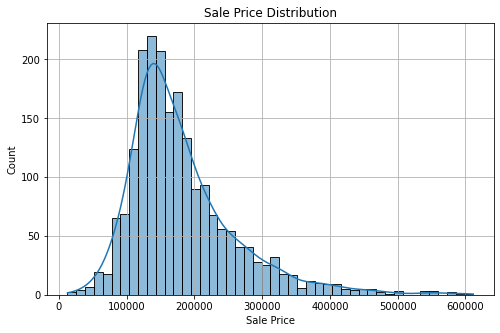

In [710]:
# Plotting Sale Price distribution
plt.figure(figsize=(8, 5))
sns.histplot(train.SalePrice, kde=True)
plt.title('Sale Price Distribution');
plt.xlabel('Sale Price');
plt.grid()


The Sale Price has a normal distribution that is skewed positively, with majority of sales hovering between \\$100k - $200k.

I've always thought location is a big driving force behind price, so I want to take a look at the distribution of sale prices related to location and see how many different areas we're working with.

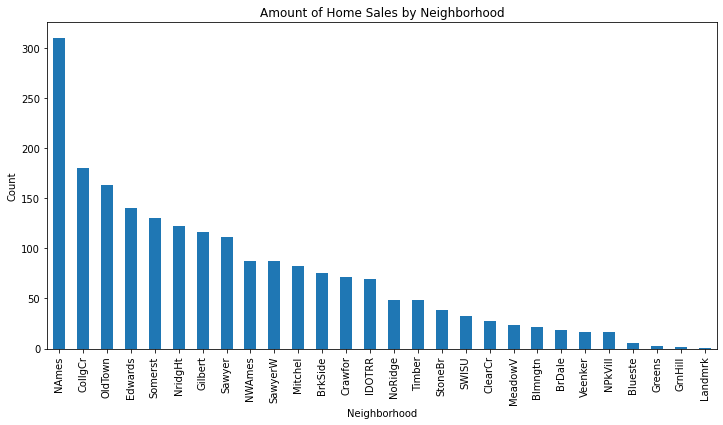

In [711]:
# Plotting home sales by area
plt.figure(figsize=(12,6))
train['Neighborhood'].value_counts().plot(kind='bar')
plt.xlabel('Neighborhood')
plt.ylabel('Count')
plt.title('Amount of Home Sales by Neighborhood');

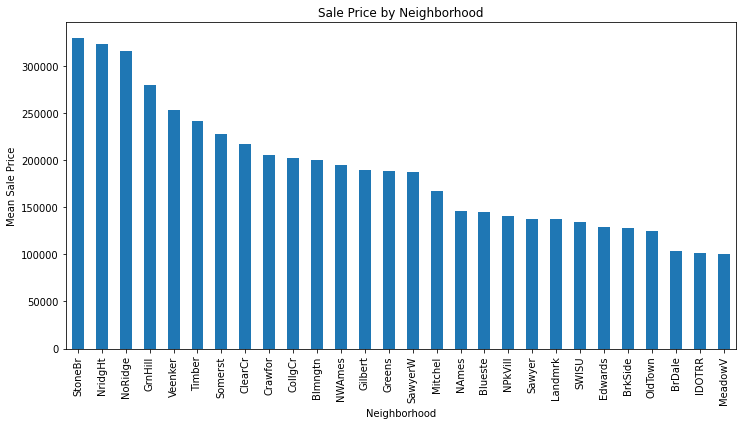

In [712]:
# PLotting mean sale price by neighborhood
plt.figure(figsize=(12,6))
train.groupby(by=['Neighborhood'])['SalePrice'].agg('mean').sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Sale Price')
plt.title('Sale Price by Neighborhood');

The MeadowV neighborhood accounted for some of the lowest sales in price and quantity. The highest selling price in the Stonbr neighborhood accounted for some of the lowest amount of sales. We can also see that NAmes accounts for some of the highest sale counts while hovering right around the mean sale price. I'll investigate in the analysis if the neighborhood really does have an affect on sale prices.

Let's look at a few more distributions to get a feel for the data set.

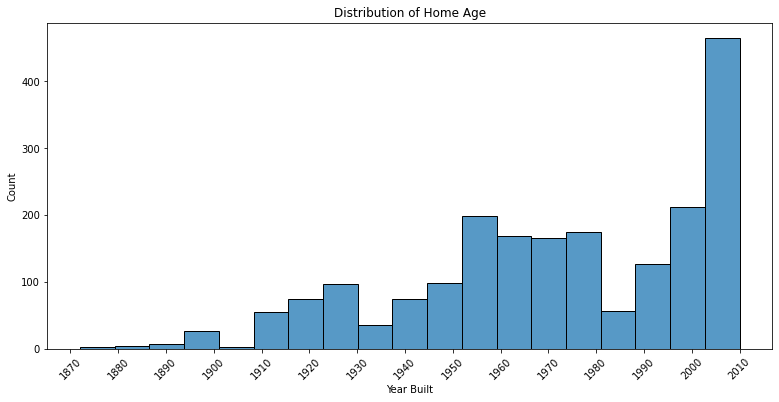

In [713]:
# Plotting distribution of year that home was built

plt.figure(figsize=(13,6))
sns.histplot(train['Year Built'].astype('int'))
plt.xticks(range(1870, 2020, 10), rotation=45)
plt.title('Distribution of Home Age');

There is quite the spread on age of homes. There are homes dating back before 1900, while most were built after 2000.

(0.0, 40000.0)

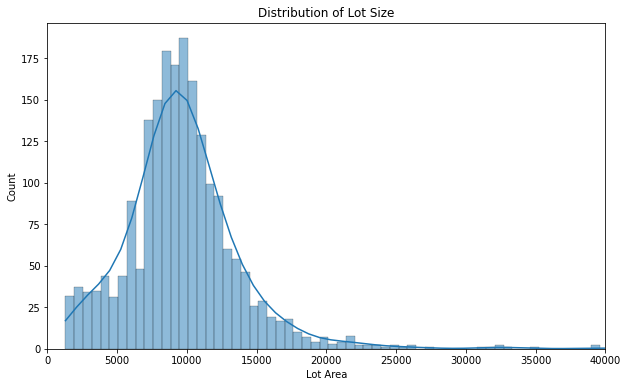

In [714]:
plt.figure(figsize=(10,6))
sns.histplot(train['Lot Area'], kde=True)
plt.title('Distribution of Lot Size')
plt.xlim(0, 40000)

There is a huge spread of lot sizes as you would imagine, and a couple of outliers past 40,000 sqft. This distribution is positively skewed with majority of lot sizes hovering around 10,000 sqft.

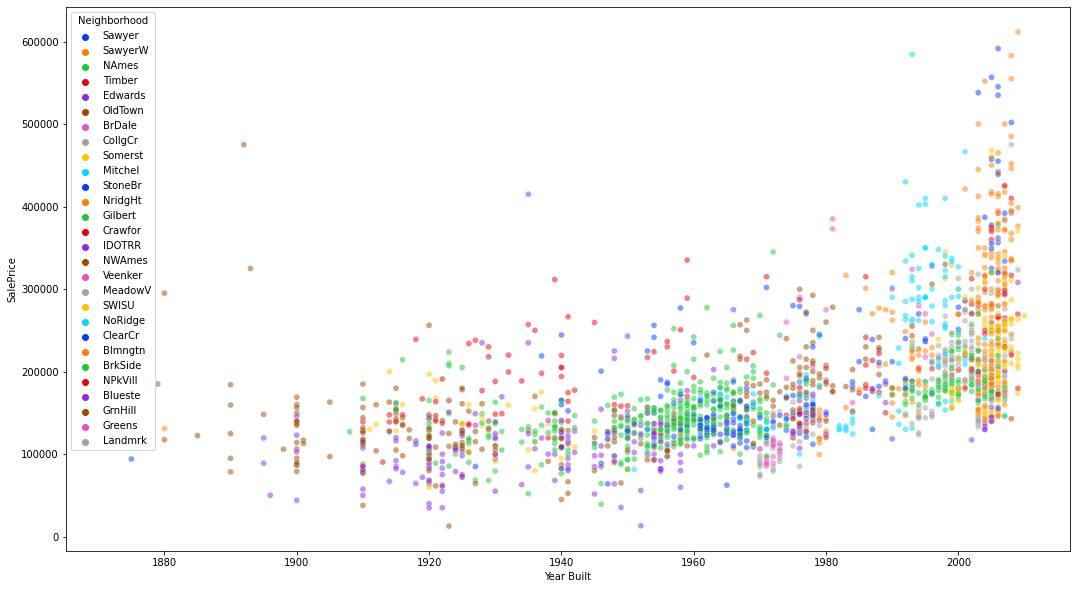

In [715]:
# Plotting sale price vs year built with the neighborhoods as hue.
plt.figure(figsize=(18,10))
sns.scatterplot(
    data=train,
    x=train['Year Built'].astype('int'),
    y='SalePrice',
    hue='Neighborhood',
    alpha=0.5,
    palette='bright'
);

OK - I'll admit this graph is a little too busy, but I thought it was cool so I left it in. This gives a decent idea of the relations ship between year built and house prices, as well as what neighborhoods are older than others.

Text(0, 0.5, 'Sale Price')

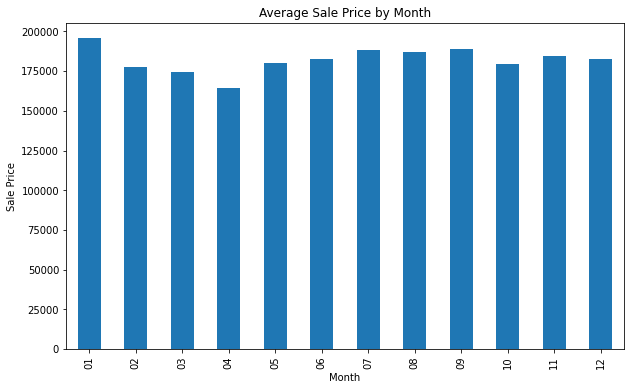

In [716]:
# Plotting average sale price by month over the.

df = train.copy()
df.sort_values(by='Yr Sold')
plt.figure(figsize=(10,6))
month_map = {'1': '01', '2': '02', '3': '03',
             '4': '04', '5': '05', '6': '06',
             '7': '07', '8': '08', '9': '09',
             '10': '10', '11': '11', '12': '12'}
df['Mo Sold'] = df['Mo Sold'].map(month_map)
df.groupby(['Mo Sold'])['SalePrice'].agg('mean').plot(kind='bar')
plt.title('Average Sale Price by Month')
plt.xlabel('Month')
plt.ylabel('Sale Price')

This graph surprised me as I thought there would be a larger distinction between different months, although it looks like April is the clear loser here.

Instead of plotting an eye-numbing correlation heatmap, I'm just going to list the correclation coefficients in a nice table. You're welcome.

In [717]:
correlate = train.corr()['SalePrice'].sort_values(ascending=False)
correlate

SalePrice          1.000000
Total SF           0.825573
Overall Qual       0.804234
Exter Qual         0.715806
Kitchen Qual       0.693903
Garage Cars        0.648110
Total Baths        0.631838
Bsmt Qual          0.618307
Fireplace Qu       0.538851
Mas Vnr Area       0.512815
TotRms AbvGrd      0.508716
Fireplaces         0.472844
Heating QC         0.459342
BsmtFin SF 1       0.446691
Bsmt Exposure      0.426968
BsmtFin Type 1     0.351507
Lot Frontage       0.339260
Open Porch SF      0.337285
Wood Deck SF       0.327987
Lot Area           0.302394
Paved Drive        0.290779
Electrical         0.246821
Has Garage         0.231090
Bsmt Cond          0.228246
Bsmt Unf SF        0.191198
Bedroom AbvGr      0.135214
Screen Porch       0.134673
Functional         0.125820
3Ssn Porch         0.048762
Exter Cond         0.036425
Utilities          0.026430
BsmtFin SF 2       0.016414
BsmtFin Type 2     0.014067
Misc Val          -0.010331
Low Qual Fin SF   -0.041642
Land Slope        -0

I will just focus on these top 10 for now.

In [718]:
correlate.abs().sort_values(ascending=False).head(10)

SalePrice       1.000000
Total SF        0.825573
Overall Qual    0.804234
Exter Qual      0.715806
Kitchen Qual    0.693903
Garage Cars     0.648110
Total Baths     0.631838
Bsmt Qual       0.618307
House Age       0.572771
Remodel Age     0.551697
Name: SalePrice, dtype: float64

In [719]:
correlate.abs().sort_values(ascending=False).tail(10)

Overall Cond       0.097259
Land Slope         0.058017
3Ssn Porch         0.048762
Low Qual Fin SF    0.041642
Exter Cond         0.036425
Utilities          0.026430
BsmtFin SF 2       0.016414
BsmtFin Type 2     0.014067
Misc Val           0.010331
Has Pool                NaN
Name: SalePrice, dtype: float64

In [720]:
train.drop(columns=[
    'Overall Cond',
    'Land Slope',
    '3Ssn Porch',
    'Low Qual Fin SF',
    'Exter Cond',
    'Utilities',
    'BsmtFin SF 2',
    'BsmtFin Type 2',
    'Misc Val',
    'Has Pool',
    'Year Built',
    'Year Remod/Add',
    'Garage Yr Blt'],
    inplace=True
)

This makes sense and is somewhat intuitive, however they must love their fireplaces & basements in Ames. It appears I will have enough information to perform the appropriate modeling. I will look to compare the top ten features correlated with high sales price to see if the modeling agrees. This will be performed in the Modeling section.

Now I will prepare some visuals to gain a deeper understanding of the data and how to approach the modeling.

Text(0.5, 1.0, 'Overall Quality to Sale Price')

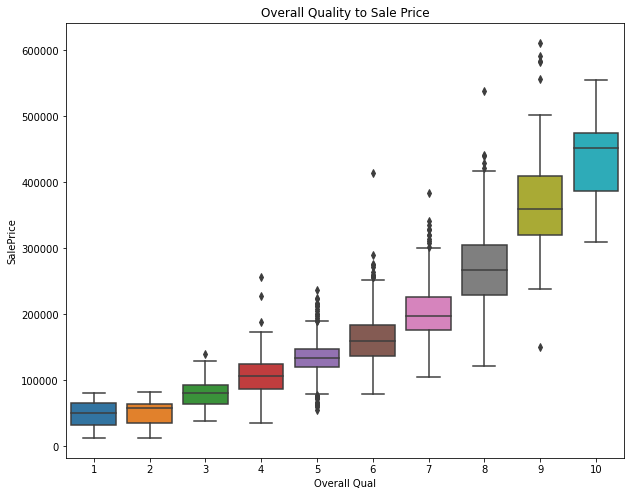

In [721]:
# Boxplot of overall quality to sale price
plt.figure(figsize=(10, 8))
sns.boxplot(x=train['Overall Qual'], y=train['SalePrice'])
plt.title('Overall Quality to Sale Price')

The boxplot corroborates with the correlation values that as the quality increases, so does the sale price. There are quite a few outliers in the medium quality range.

Text(0.5, 1.0, 'Sale Price vs Total SF')

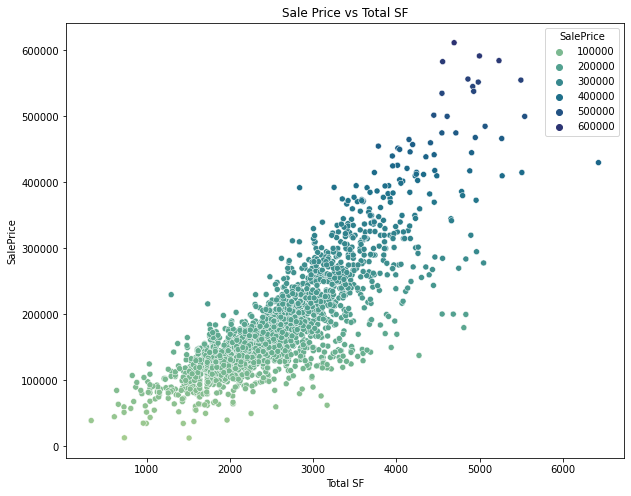

In [722]:
# Plotting Sale Price vs. Total SF
plt.figure(figsize=(10, 8))
pal = sns.color_palette("crest", as_cmap=True)
sns.scatterplot(x=df['Total SF'], y=df['SalePrice'], hue=df['SalePrice'], palette=pal)
plt.title('Sale Price vs Total SF')

The graph above shows a steep corelation in Sales Price with the increase in square footage, as one would assume.

Text(0.5, 1.0, 'Sale Price vs Remodel Age')

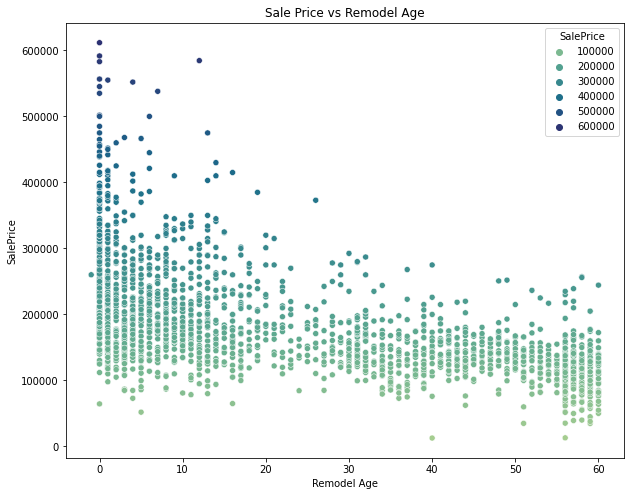

In [723]:
plt.figure(figsize=(10, 8))
pal = sns.color_palette("crest", as_cmap=True)
sns.scatterplot(x=df['Remodel Age'], y=df['SalePrice'], hue=df['SalePrice'], palette=pal)
plt.title('Sale Price vs Remodel Age')

This is good news for home owners looking to remodel. The graph shows the fresher the remodel, the higher the average on sale price.

Text(0.5, 1.0, 'Sale Price vs House Age')

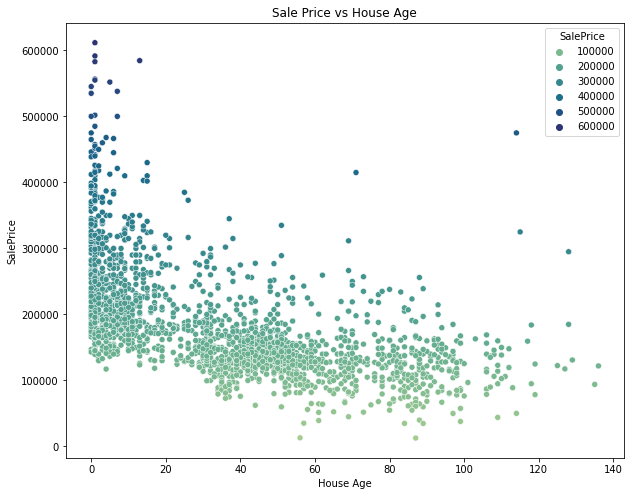

In [724]:
# Plotting Sale Price vs House Age
plt.figure(figsize=(10, 8))
pal = sns.color_palette("crest", as_cmap=True)
sns.scatterplot(x=df['House Age'], y=df['SalePrice'], hue=df['SalePrice'], palette=pal)
plt.title('Sale Price vs House Age')

As one would expect, The average sale price falls as the home age increases. However, there are still some older homes that are being sold for relatively larger prices. Hopefully the modeling will point us to key features that could cause this.

(0.0, 5.0)

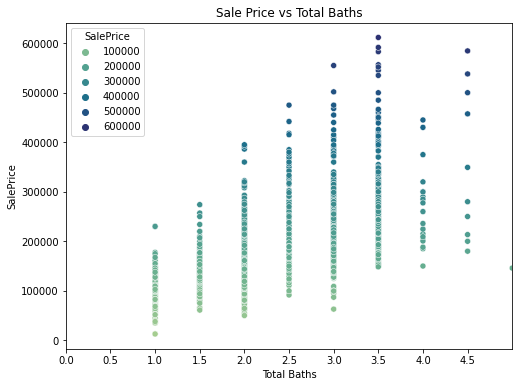

In [725]:
# Plotting sale price vs. total number of bathrooms
plt.figure(figsize=(8,6))
pal = sns.color_palette("crest", as_cmap=True)
sns.scatterplot(x=df['Total Baths'], y=df['SalePrice'], hue=df['SalePrice'], palette=pal)
plt.title('Sale Price vs Total Baths')
plt.xticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])
plt.xlim(0, 5)

I get it. I like bathrooms too! It looks like adding a bathroom will likely increase the sale price, but we'll check in the modeling phase.

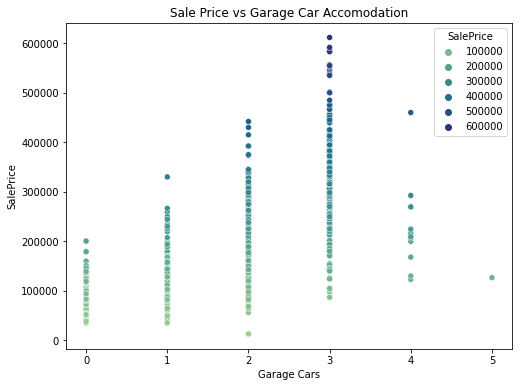

In [726]:
# Plotting sale price vs garage cars
plt.figure(figsize=(8,6))
pal = sns.color_palette("crest", as_cmap=True)
sns.scatterplot(x=df['Garage Cars'], y=df['SalePrice'], hue=df['SalePrice'], palette=pal)
plt.title('Sale Price vs Garage Car Accomodation');

It appears three car garages is the key goal for maximizing home sale price.

In [727]:
# Creating dataframe for sorting neighborhoods by price and plotting
hoods = pd.DataFrame(train['Neighborhood'].value_counts())
hoods = pd.DataFrame(
    (round(train.groupby(['Neighborhood'])['SalePrice'].mean() / 1000)) \
    .sort_values(ascending=False)
)

Text(0.5, 1.0, 'Average Sale Price by Neighborhood')

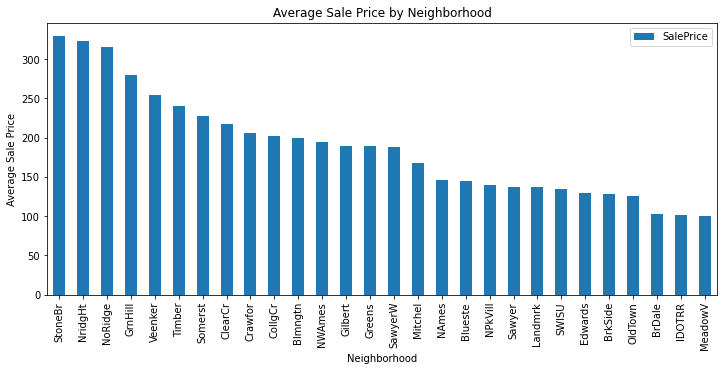

In [728]:
# Plotting neighborhods by price
hoods.plot(kind='bar', figsize=(12,5))
plt.xlabel('Neighborhood')
plt.ylabel('Average Sale Price')
plt.title('Average Sale Price by Neighborhood')

This gives a good overview of what neighborhoods have the highest and lowest average sale prices

# Modeling

Alright, alright. We made it!!! We've seen some interesting stuff so far, but let's get right into the modeling.

There are quite a few categorical and dummy columns created from this data set, so I'm going to jump straight into regularizing the data for a Ridge regression model.

In [729]:
# Creating dummy columns
train = pd.get_dummies(data=train, drop_first=True )
test = pd.get_dummies(data=test, drop_first=True )

In [730]:
xvars = [name for name in train.columns]
xvars.remove('SalePrice')

In [731]:
test_col_miss = [col for col in xvars if col not in test.columns]
for col in test_col_miss:
    test[col] = 0

In [732]:
# Creating X values for models
X_sub = test[xvars]
X = train[xvars]

I'm going to fit a Linear Regression model to understand the starting point.

In [733]:
# Fitting simple Linear Regression model.

lr = LinearRegression()
y = train['SalePrice']
lr.fit(X, y)
lr.score(X, y)

0.9270464526324536

This score makes sense as the data is likely overfit. But let's investigate further.

In [734]:
preds = lr.predict(X)

In [735]:
# Finding RMSE
rmse = np.sqrt(mean_squared_error(y, preds))
rmse

21405.383909613767

I'm pretty happy with this RMSE, but let's try some other regression models and see if we can reduce it.

In [736]:
# Splitting up data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [737]:
# Fitting the train model and getting R sq value
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.9284974347234859

In [738]:
# Getting train predictions
preds = lr.predict(X_train)

In [739]:
# Getting train RSME
rmse = np.sqrt(mean_squared_error(y_train, preds))
rmse

21311.013522684338

In [740]:
# Getting test R sq value
lr.score(X_test, y_test)

0.9014436286860146

In [741]:
# Getting test RSME
preds = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

24309.45289428881

This RMSE got a little worse and indicates to me my model is overfit. Let's try regularizing the model to see if this helps.

In [742]:
# Scaling data for the Ridge and LASSO regressions
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)
Z_sub = sc.transform(X_sub)

In [743]:
# The below code is taken from GA Lesson 4.02
#
# Instantiate.

ridge_model = Ridge(alpha=10)

# Fit.
ridge_model.fit(Z_train, y_train)

# Evaluate model using R2.
print(ridge_model.score(Z_train, y_train))
print(ridge_model.score(Z_test, y_test))

0.9280459400351895
0.9038666330680987


In [744]:
# Getting train RSME
preds = ridge_model.predict(Z_train)
rmse = np.sqrt(mean_squared_error(y_train, preds))
rmse

21378.190610566304

In [745]:
# Getting test RSME
preds = ridge_model.predict(Z_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

24008.76986823525

Oooh. It got a lot worse with the Ridge. Let's try the cross val Ridge Regression and see if we can get this value a little lower.

In [746]:
# The below code is taken from GA Lesson 4.02
#
# Setting up RidgeCV regression
r_alphas = np.logspace(0, 20, 500)

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas=r_alphas, scoring='mse', cv=5)

# Fit model using best ridge alpha!
ridge_cv = ridge_model.fit(Z_train, y_train)

In [747]:
# Outputting R sq scores
print(ridge_cv.score(Z_train, y_train))
print(ridge_cv.score(Z_test, y_test))

0.9280459400351895
0.9038666330680987


In [748]:
# Checking train RSME
preds = ridge_cv.predict(Z_train)
rmse = np.sqrt(mean_squared_error(y_train, preds))
rmse

21378.190610566304

In [749]:
# Checking test RSME
preds = ridge_cv.predict(Z_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

24008.76986823525

Let's try out the LASSO modeling now and see if we can get some better looking metrics.

In [750]:
# This code was taken from Lesson 4.02

# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=5000)

# Fit model using best ridge alpha!
lasso_cv.fit(Z_train, y_train);

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26337566814.852173, tolerance: 837748881.5164454
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14935046716.30371, tolerance: 814142982.8573381
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1765072030.6063232, tolerance: 832978835.9517254
  tol, rng, random, positive)


In [751]:
# Checking train R sq score
lasso_cv.score(Z_train, y_train)

0.9284948211774652

In [752]:
# Checking train RSME
preds = lasso_cv.predict(Z_train);
rmse = np.sqrt(mean_squared_error(y_train, preds))
rmse

21311.40299686213

In [753]:
# Checking test R sq score
lasso_cv.score(Z_test, y_test)

0.9017658738459985

In [754]:
# Checking train RSME
preds = lasso_cv.predict(Z_test);
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

24269.67861478741

This lasso model didn't do much better. It still look like the model is overfit.

Between all of the models, it appears our simple Linear Regression will give the best RMSE. I will proceed with gathering the key features to improve as to maximize sale price.

In [755]:
# Fitting Linear Regression model again
lr = LinearRegression()
y = train['SalePrice']
lr.fit(X, y)
preds = lr.predict(X);

In [756]:
# Grabbing coefficients from model
coef = lr.coef_

In [757]:
# Creating a data frame because it's easier to work with
items = {'Feature': X.columns, 'Coefficient': coef}
df = pd.DataFrame(items)

In [758]:
# Filtering out dummy columns
indx = []
for feat in df['Feature']:
    if '_' in feat:
        df.drop(df[df['Feature'] == feat].index, inplace=True)


In [759]:
# Sorting coefficients to find the top ten.
df.sort_values(by='Coefficient', ascending=False).head(15)

,Feature,Coefficient
3,Overall Qual,8989.911344
5,Exter Qual,7723.411826
16,Kitchen Qual,7262.987453
18,Functional,7059.962758
21,Garage Cars,6290.108194
8,Bsmt Exposure,3610.116554
19,Fireplaces,3246.811257
17,TotRms AbvGrd,2017.098115
31,Total Baths,1952.350751
33,Has Garage,1914.875315


I'm not interested in the Basement Exposure category or the Functional category, as these are not items the home owners can change.

From the top 10 items I filtered from the coefficients, the quality of certian home aspects are among the top three. The top ten items here is very differnt from the values we saw earlier correlating features with sale prices, but do shed some light on items a home owner can focus in on during renovations in order to improve sale price.

In [760]:
# Gathering predictions
preds_sub = lr.predict(X_sub)
preds = lr.predict(X)

In [761]:
# Gathering residuals
resids = y - preds

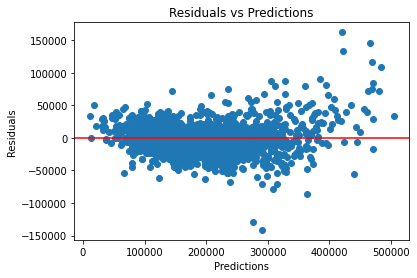

In [762]:
# Plotting residuals vs predictions for test data
plt.scatter(preds, resids)
plt.axhline(0, color='red');
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions');

The residuals are largely congregated around zero. Overall these residuals could be better, especially when predicting the price of high priced homes, but I'm happy with these results.

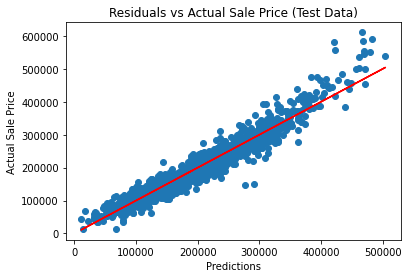

In [763]:
# Plotting residuals vs predictions for test data
plt.scatter(preds, y)
plt.plot(preds, preds, color='red')
plt.xlabel('Predictions')
plt.ylabel('Actual Sale Price')
plt.title('Residuals vs Actual Sale Price (Test Data)');

This shows a pretty linear relationship between the predictions and actual values. Overall these residuals could be better, especially when predicting the price of high priced homes, but I'm happy with these results.

# Kaggle Competition Export

I will go ahead and export these predictions for the Kaggle competition here.

In [764]:
# Creating separate DataFrame to export
sub = {'Id': test['Id'][:878], 'SalePrice': preds_sub[:878]}
sub_df = pd.DataFrame(sub)

In [765]:
# Verifying shape is appropriate for submission
sub_df.shape

(878, 2)

In [766]:
# Exporting DataFrame
sub_df.to_csv(index=False, path_or_buf='./datasets/submission.csv')

---
# Conclusion

Our model showed there are some key areas home owners can improve in order to increase the sale price of their home in Ames, IA. The table below can be interpreted as every increase in a single unit from the feature column, the home seller can expect in increase in sale price equal to the coefficient (in dollars). For instance, assuming all other features are held constant, if the 'Overall Qual' of the home is increased by one grade, the seller can expect an $8,890 increase in sale price.

|**Feature**|**Coefficient (Dollar Increase in Sales Price**|
|---|---|
|Overall Qual|8990|
|Exterior Qual|7723|
|Kitchen Qual|7263|
|Garage Cars|7060|
|Fireplaces|3247|
|Total Rooms Above Ground|2017|
|Total Baths|1953|
|Has Garage|1915|
|Heating QC|1721|
|Paved Drive|1450|


The top three items are all related to the quality of the home: Overall, Exterior and Kitchen. The quality refers to the quality of finishes used in the hom: floors, tile, countertops, cabinets, molding, craftsmenship etc. These are mainly aesthetic features that can be modified relatively easily. The good thing are these provide the highest increase in sale price, as compared with something that will be highly unlikely to be modified such as with Garage Cars.

From the model, I highly recommend home owners focus on upgrading or renovating these key features:

    Overall Quality (+$8,990)
Exterior Quality (+$7,723)
    Kitchen Quality (+$7,263)
Heating QC (+$1,721)
    Paving the Driveway (+$1,450)
    
If major remodels are being planned, I urge them to consider updating the following features as the modeling suggests the are the strongest factors correlated with increasing sales prices:

    Increase in the number of cars a garage can accommodate (+$7,060)
Adding a fireplace (+$3,247)
    Adding a bathroom (+$1,953)
Adding a bedroom (+$2,017)

The future steps to move this project forward are trying to refine the modeling in order to better predict sale prices of higher priced homes. This in theory should have a trickle down effect of reducing the root mean squared error of all home price predictions, providing an overall better model.
 